In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,depi,vmax,time,title,cblabel,ylabel):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    # axv.set_xticklabels(np.round(np.linspace(f_lons[lonW],f_lons[lonE-1],4),2))
    
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 

files = ['for_jan18','for_jan18_PR','backVS_jan18','backrosVS_jan18']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2018,2,11)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)

print(len(dates))   
   
date = dt.datetime(2018,6,10)
enddate = dt.datetime(2018,9,17)

while date<=enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+= dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


64


/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cstang/conda_envs/analysis-camryn/lib/pyt

### Importing data for summer/winter comparison

In [10]:
datafvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jul18_s7t21/ariane_positions_quantitative.nc')

In [8]:
section_transpfvs = []
sectionnum = [0,2,3,4,5,6]

starttime = 1
endtime = 168

for section in sectionnum:
    section_transpfvs.append(get_datat(datafvs,section,starttime,endtime,))
    
section_transpfvs

[549714.7121161793,
 29441.356930736445,
 70.28909350509404,
 5921.754855595813,
 3674.0503695276143,
 76335.49015953543]

In [9]:
mdfvs = get_secdata(datafvs,0)
age_mdfvs = mdfvs['final_age']

transp_reffvs = np.sum(mdfvs['final_transp'][age_mdfvs >= 24])/168
total_md = np.sum(mdfvs['final_transp'])/168

print(total_md)
print(transp_reffvs)

section_transpfvs_md = np.array(section_transpfvs)
section_transpfvs_md[0] = transp_reffvs.values

<xarray.DataArray 'final_transp' ()>
array(549714.71211618)
<xarray.DataArray 'final_transp' ()>
array(51228.19727729)


In [11]:
section_transpfvs_jul = []

for section in sectionnum:
    section_transpfvs_jul.append(get_datat(datafvs07,section,starttime,endtime))
    
mdfvs_jul = get_secdata(datafvs07,0)
age_mdfvs_jul = mdfvs_jul['final_age']

transp_reffvs_jul = np.sum(mdfvs_jul['final_transp'][age_mdfvs_jul >= 24])/168
total_md_jul = np.sum(mdfvs_jul['final_transp'])/168

print(total_md_jul)
print(transp_reffvs_jul)

section_transpfvs_md_jul = np.array(section_transpfvs_jul)
section_transpfvs_md_jul[0] = transp_reffvs_jul.values

<xarray.DataArray 'final_transp' ()>
array(327423.05634854)
<xarray.DataArray 'final_transp' ()>
array(41304.53357312)


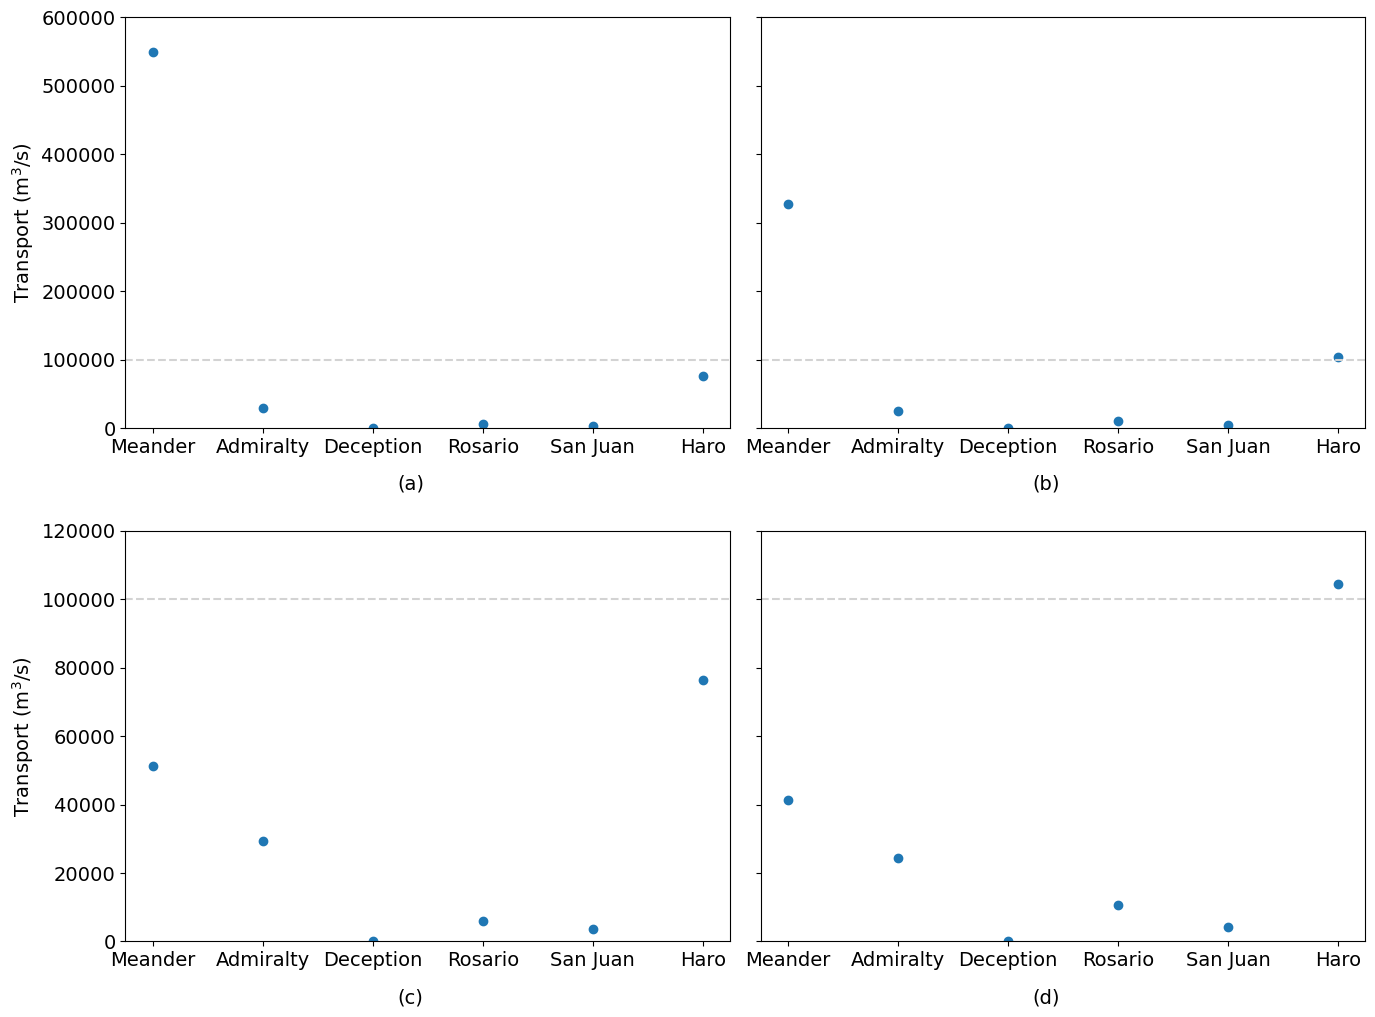

In [14]:
sectionnumplot = [1,2,3,4,5,6]
plt.rcParams['font.size'] = 14

fig,[[ax1,ax2],[ax3,ax4]] =plt.subplots(2,2,figsize=(16,12))

ax1.scatter(sectionnumplot,section_transpfvs)
ax1.set_xticks(sectionnumplot)
ax1.set_xticklabels(['Meander','Admiralty','Deception','Rosario','San Juan','Haro'],rotation=0)
ax1.set_ylabel(f'Transport (m$^3$/s)')
# ax1.set_xlabel('Final Boundary')
ax1.set_ylim([0,600000])
ax1.axhline(100000,color='lightgrey',ls='--')

ax2.scatter(sectionnumplot,section_transpfvs_jul)
ax2.set_xticks(sectionnumplot)
ax2.set_xticklabels(['Meander','Admiralty','Deception','Rosario','San Juan','Haro'],rotation=0)
# ax[1].set_ylabel(f'Transport (m$^3$/s)')
# ax2.set_xlabel('Final Boundary')
ax2.set_yticklabels([])
ax2.set_ylim([0,600000])
ax2.axhline(100000,color='lightgrey',ls='--')

ax1.text(0.45, -0.15, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.15, "(b)", transform=ax2.transAxes)

ax3.scatter(sectionnumplot,section_transpfvs_md)
ax3.set_xticks(sectionnumplot)
ax3.set_xticklabels(['Meander','Admiralty','Deception','Rosario','San Juan','Haro'],rotation=0)
ax3.set_ylabel(f'Transport (m$^3$/s)')
# ax3.set_xlabel('Final Boundary')
ax3.set_ylim([0,120000])
ax3.axhline(100000,color='lightgrey',ls='--')

ax4.scatter(sectionnumplot,section_transpfvs_md_jul)
ax4.set_xticks(sectionnumplot)
ax4.set_xticklabels(['Meander','Admiralty','Deception','Rosario','San Juan','Haro'],rotation=0)
# ax[1].set_ylabel(f'Transport (m$^3$/s)')
# ax4.set_xlabel('Final Boundary')
ax4.set_yticklabels([])
ax4.set_ylim([0,120000])
ax4.axhline(100000,color='lightgrey',ls='--')

ax3.text(0.45, -0.15, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.15, "(d)", transform=ax4.transAxes)

fig.subplots_adjust(wspace=0.05, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/transportVS_tidalpump.png',bbox_inches='tight')